### Script Description: Vanilla SAM applied on confocal images
#### Input data: Input_Data/Confocal_Images_RGB
#### Output: mask pickle files

In [19]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageStat
from skimage import io, util, color
from scipy.optimize import linear_sum_assignment
import sys
import cv2
import pickle
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install --upgrade imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 30.6 MB/s eta 0:00:00


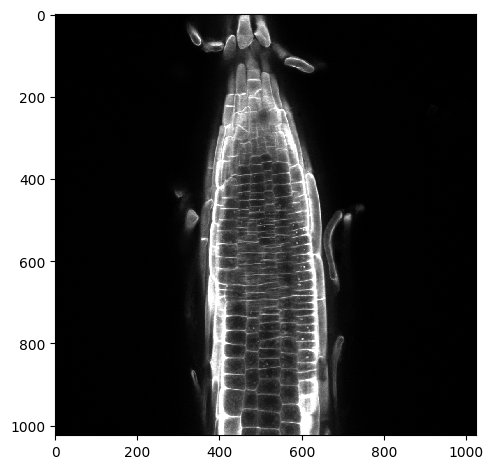

In [4]:
image = io.imread("/content/drive/MyDrive/Sanchari Confocal Images_3/12.tif")
io.imshow(image)

#### upload pre-trained SAM weights

In [6]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [7]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c6s6wq6q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c6s6wq6q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=3be87edba1589ada5578c16f26bd7b740796b6694dad5a0ef89c26e562337207
  Stored in directory: /tmp/pip-ephem-wheel-cache-2jo1be1f/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [8]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00


In [9]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [10]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [11]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [13]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [14]:
import supervision as sv
sam_result = mask_generator.generate(image)

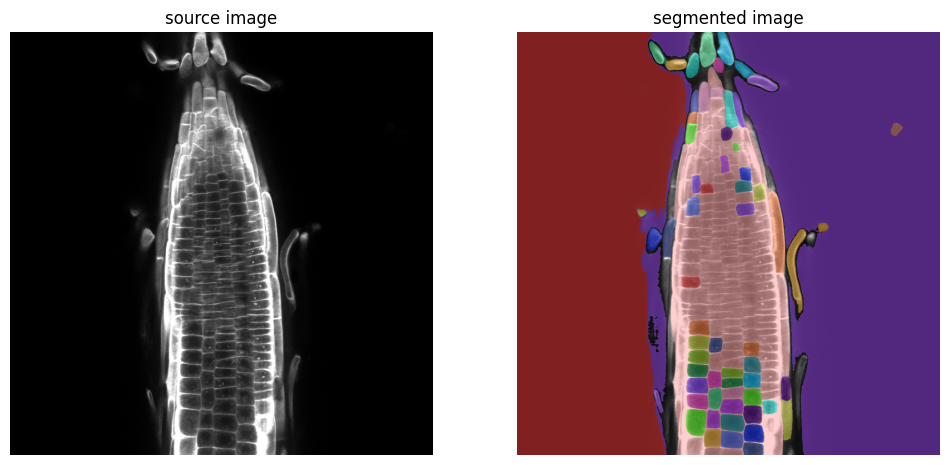

In [15]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

In [16]:
io.imsave('/content/weights/annotated_image.jpg', annotated_image)

In [17]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

In [21]:
# Mask Selection Tool

# Initialize variables
selected_masks = [False] * len(masks)

# Create a grid layout to display masks and checkboxes
grid_layout = widgets.GridspecLayout(len(masks), 3, width='60%')
mask_widgets = []

# Function to toggle mask selection
def toggle_selection(change, index):
    selected_masks[index] = not selected_masks[index]

# Function to display masks and checkboxes
def display_masks():
    for i, mask in enumerate(masks):
        checkbox = widgets.Checkbox(value=False, description='Include')
        checkbox.observe(lambda change, index=i: toggle_selection(change, index), names='value')

        mask_widgets.append(widgets.Image(value=image_to_byte_array(mask), format="png"))
        mask_widgets[-1].layout.height = '200px'

        grid_layout[i, 0] = checkbox
        grid_layout[i, 1] = mask_widgets[-1]

# Convert NumPy array to byte array for display
def image_to_byte_array(image):
    from io import BytesIO
    img_byte_array = BytesIO()
    plt.imsave(img_byte_array, image, format='png')
    return img_byte_array.getvalue()

# Display the masks and checkboxes
display_masks()

# Create a button to apply the selection
apply_button = widgets.Button(description="Apply Selection")
output = widgets.Output()

# Function to apply the selection and create new lists
def apply_selection(_):
    global selected_masks
    global unselected_masks

    # Create new lists for selected and unselected masks
    selected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if not selected]
    unselected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if selected]

    # Update mask_list and selected_masks
    selected_masks = selected_mask_list
    # unselected_masks = [False] * len(masks)
    unselected_masks = unselected_mask_list

    with output:
        print("Selected images discarded.")
        print("Unselected images included.")


# Bind button action
apply_button.on_click(apply_selection)


# Display the checkboxes, images, and the Apply button
display(widgets.VBox([grid_layout, apply_button, output]))


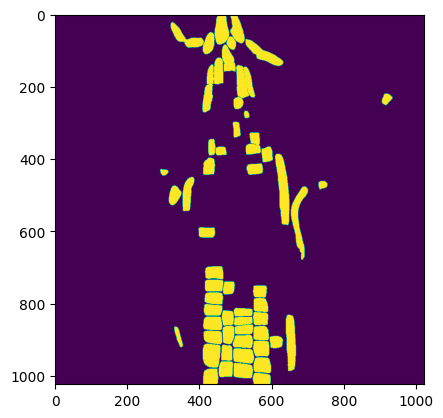

In [22]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in selected_masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

In [23]:
mask_predictor = SamPredictor(sam)

In [24]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [25]:
from ipywidgets import widgets
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget # Adjust the figure size as needed

# plt.imshow(annotated_image, cmap='gray')  # Replace 'gray' with the appropriate colormap

widget = BBoxWidget()
widget.image = encode_image("/content/weights/annotated_image.jpg")
# widget.image = encode_image("/content/drive/MyDrive/consolidated_images/6.png")
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [26]:
# initialize an empty list to store prompted masks
prompt_masks = []

<ipython-input-27-18001c45325f>:20: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())


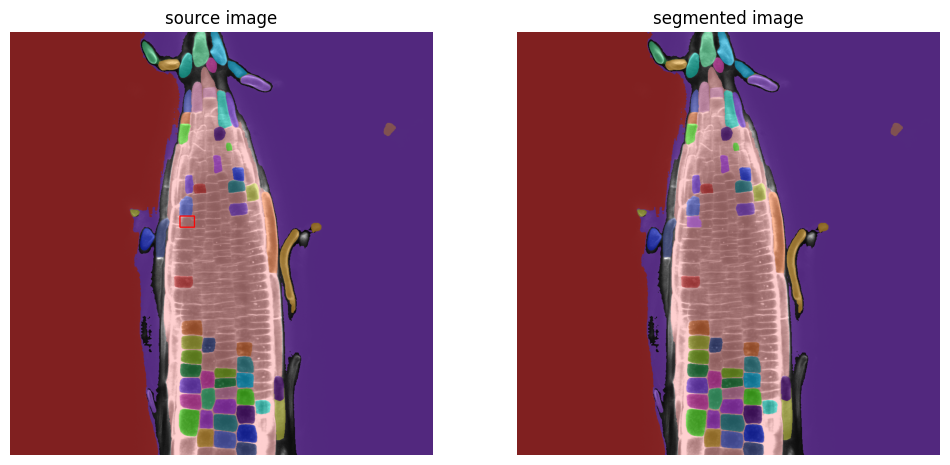

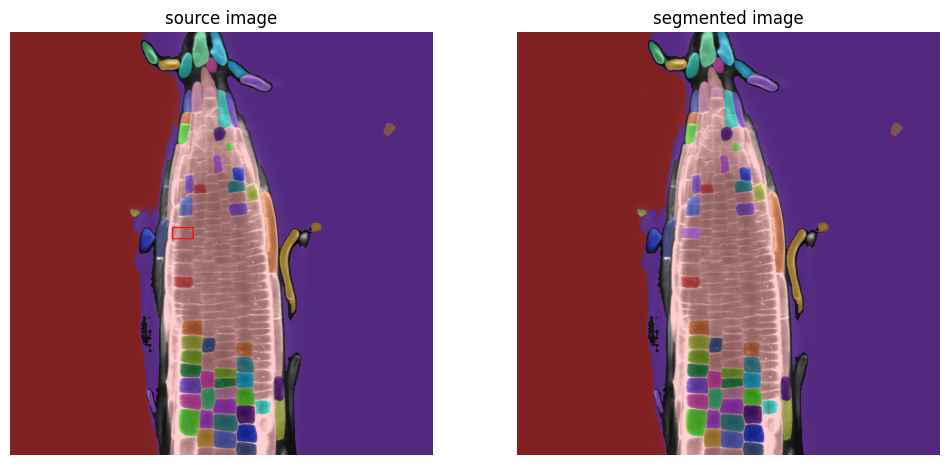

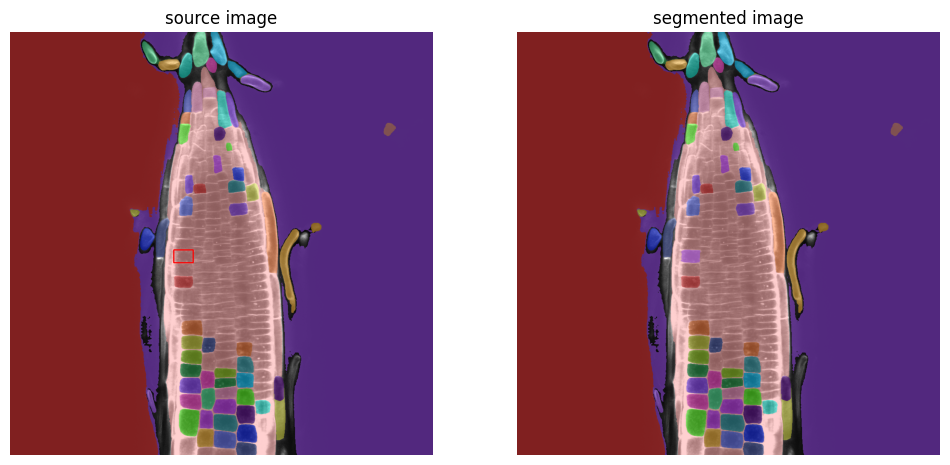

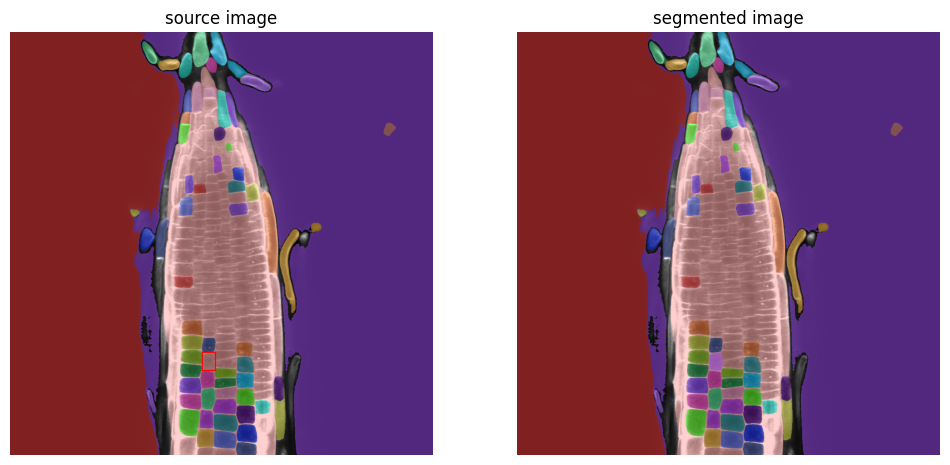

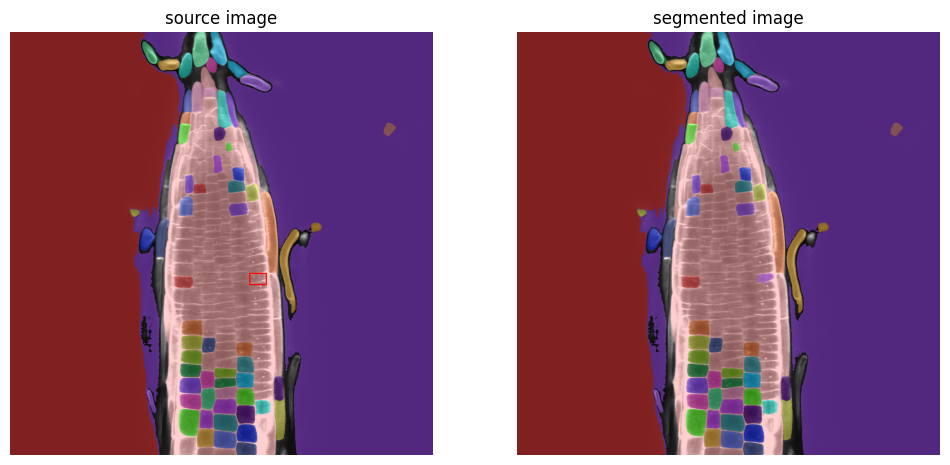

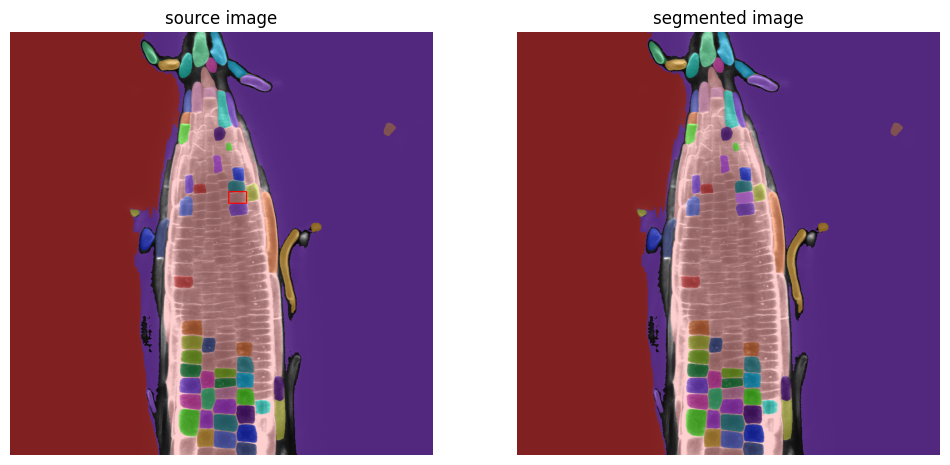

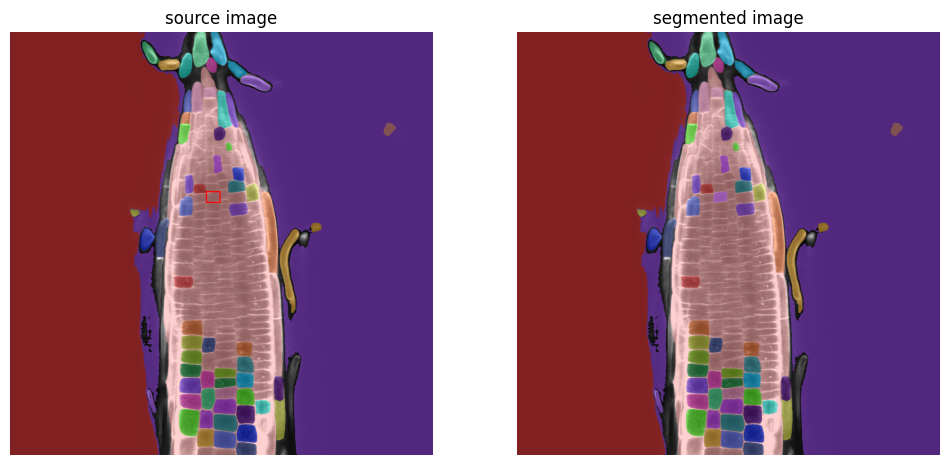

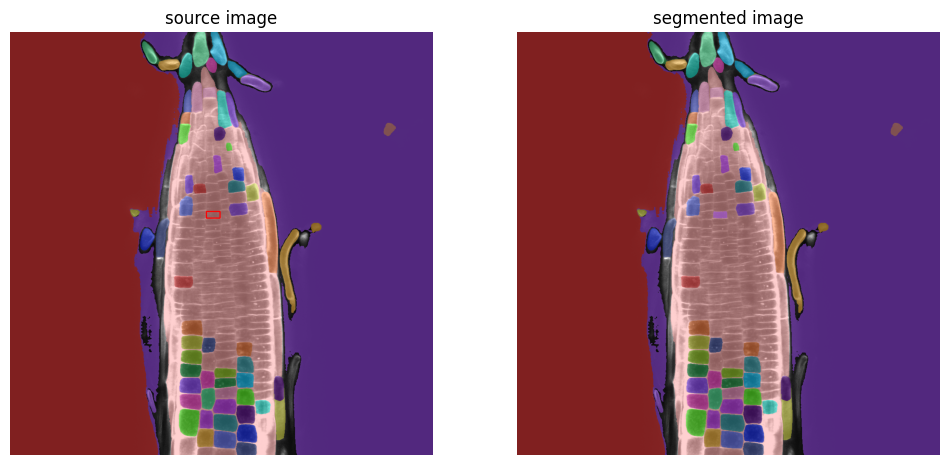

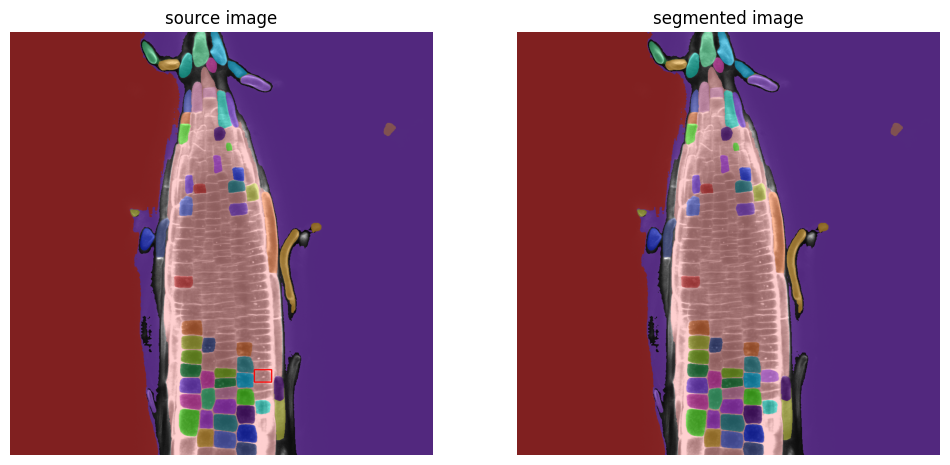

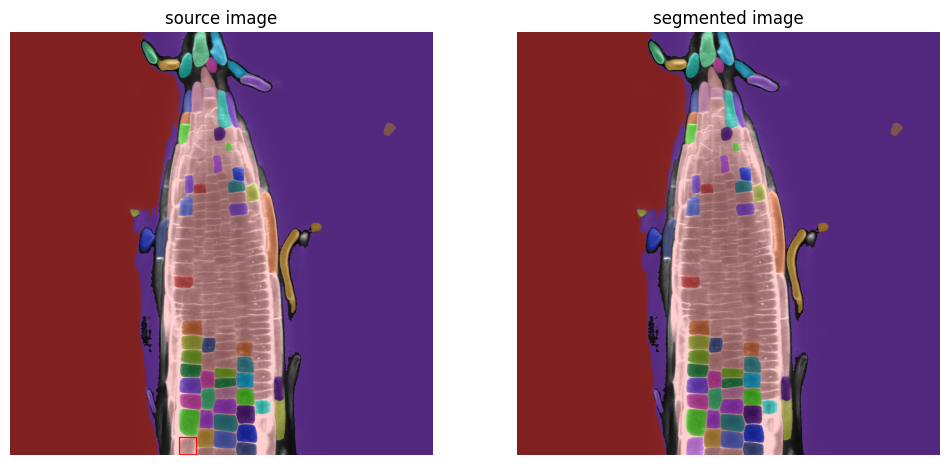

In [27]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

for i in range(len(widget.bboxes)):
  box = widget.bboxes[i] if widget.bboxes else default_box
  box = np.array([
      box['x'],
      box['y'],
      box['x'] + box['width'],
      box['y'] + box['height']
  ])
  mask_predictor.set_image(annotated_image)

  mask_prompt, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=False
  )

  prompt_masks.append(mask_prompt[0])
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
  mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=mask_prompt),
      mask=mask_prompt
  )
  # detections = detections[detections.area == np.max(detections.area)]

  source_image = box_annotator.annotate(scene=annotated_image.copy(), detections=detections, skip_label=True)
  segmented_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)

  sv.plot_images_grid(
      images=[source_image, segmented_image],
      grid_size=(1, 2),
      titles=['source image', 'segmented image']
  )

In [ ]:
total = selected_masks + prompt_masks
with open(f"/content/drive/MyDrive/masks5.pkl", 'wb') as file:
    pickle.dump(total, file)

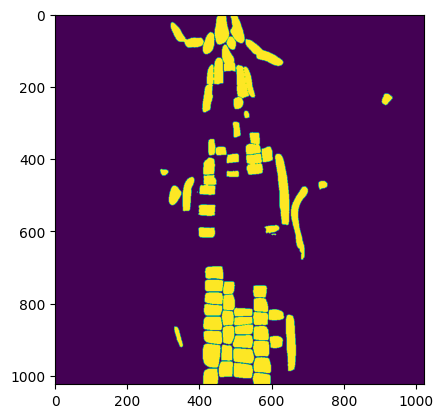

In [29]:
# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
i = 0
for object_mask in total:

    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

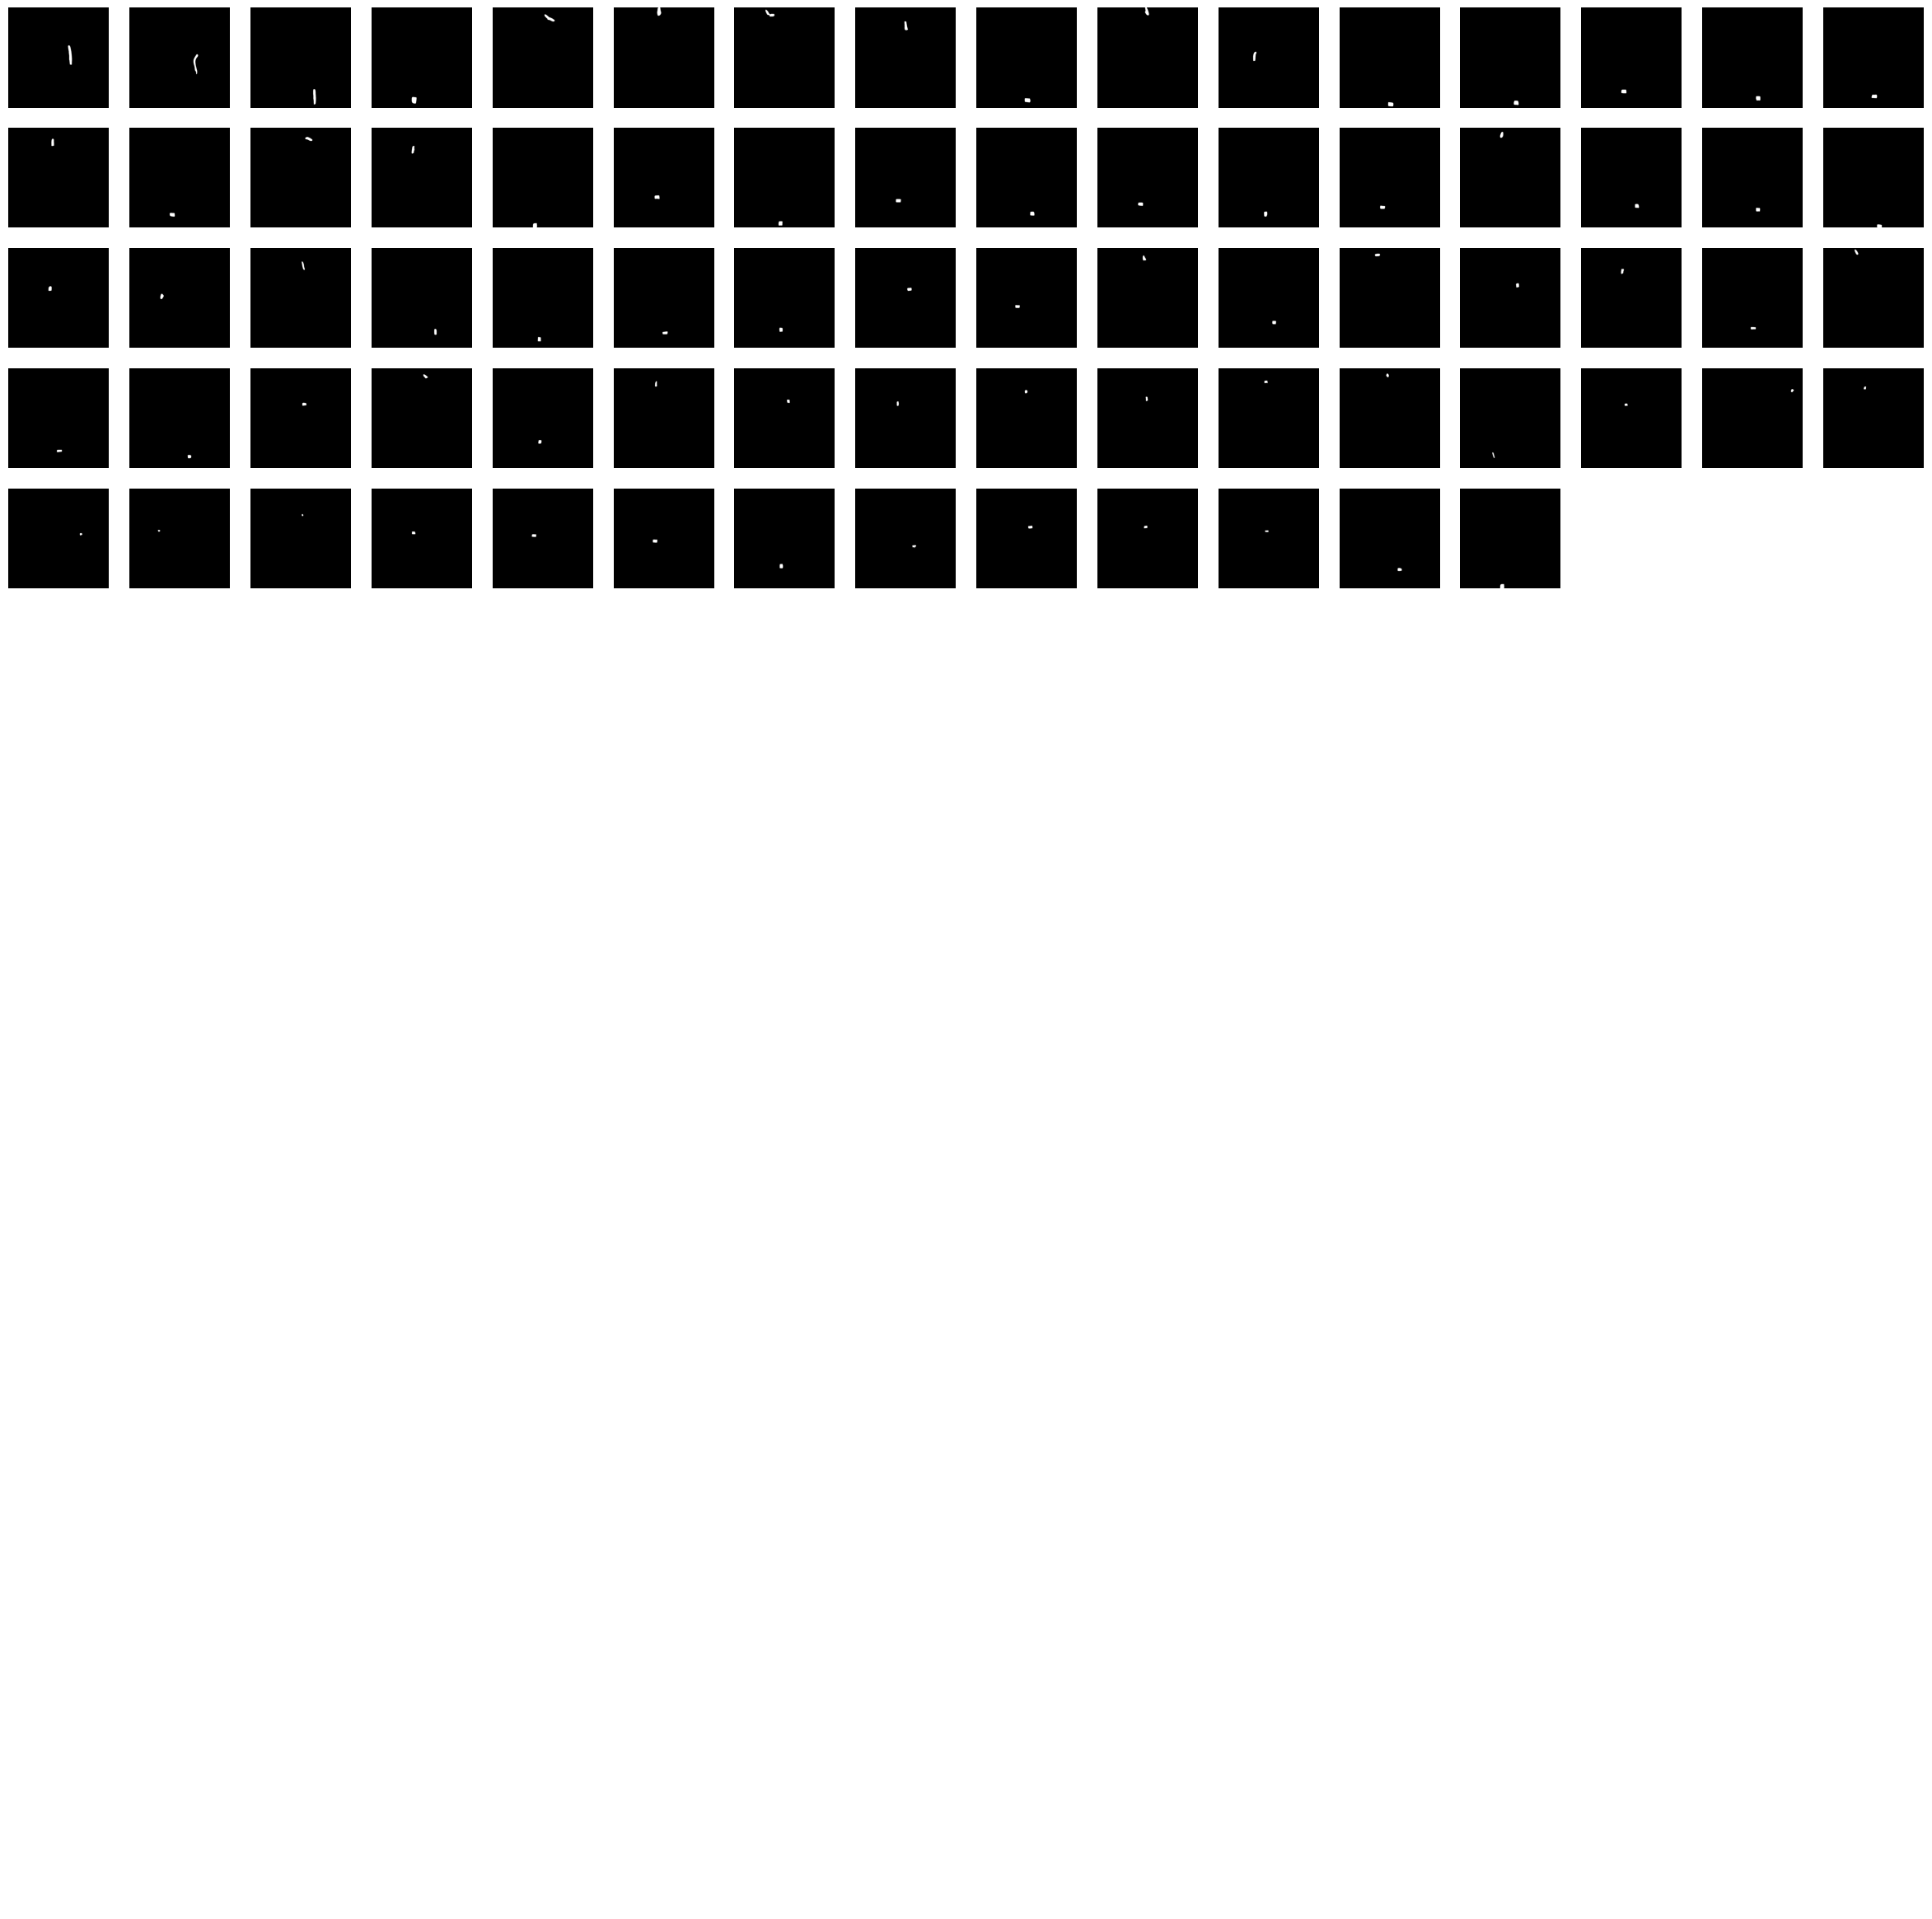

In [31]:
import supervision as sv
sv.plot_images_grid(
    images=total,
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)